<a href="https://colab.research.google.com/github/chandrusuresh/Hands-On-ML/blob/master/Ch3_Classification/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
img_size = np.uint16(np.sqrt(mnist["data"].shape[1]))
print(mnist.keys())
print('Size of image:',img_size)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])
Size of image: 28


In [3]:
X,y = mnist["data"],mnist["target"].astype(np.uint8)
print("Shape of data:",X.shape)
print("Shape of target:",y.shape)

Shape of data: (70000, 784)
Shape of target: (70000,)


## Visualize data

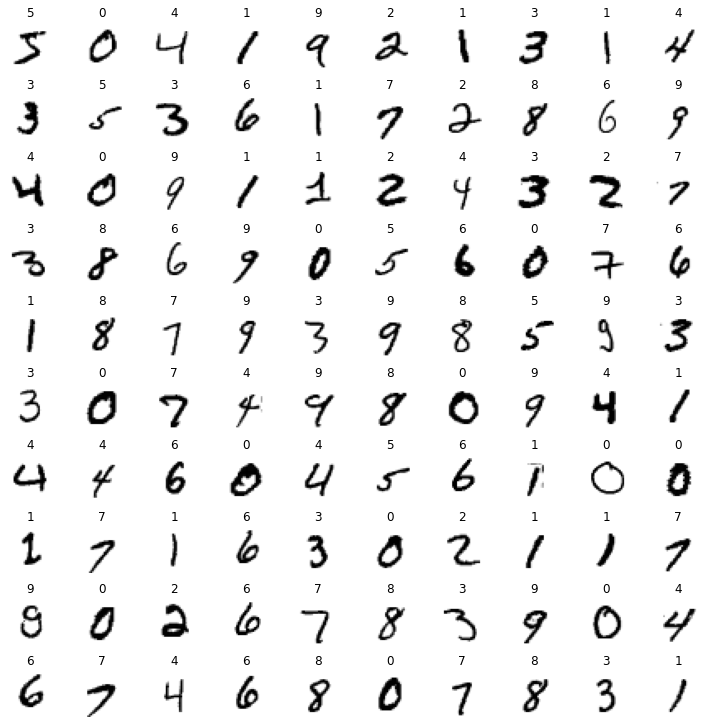

In [4]:
fig,ax = plt.subplots(10,10,figsize=(10,10))
fig.tight_layout(pad=0.001)
for i in range(10):
  for j in range(10):
    c = i*10 + j
    ax[i][j].imshow(X[c].reshape(img_size,img_size),cmap='binary')
    ax[i][j].axis('off')
    ax[i][j].set_title(str(y[c]))

## Split dataset

In [5]:
X_train,y_train,X_test,y_test = X[:60000,:],y[:60000],X[60000:,:],y[60000:]

## Binary (the "5") Classifier

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Performance Measures

### Measuring Accuracy using Cross-Validation
Cross-validation is not a good way to measure model accuracy for classifiers because in this case, only 10% of the images represent the digit "5". This means that any classifier that labels all images as a not-5 will be 90% accurate.

In [7]:
from sklearn.model_selection import cross_val_score
crossValidScore = cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")
print("Cross validation score:", crossValidScore)

Cross validation score: [0.95035 0.96035 0.9604 ]


### Confusion Matrix
The general idea is to count the number of times instances of class A are classified as Class B. The confusion matrix is a $N \times N$ matrix where $N$ is the number of class labels, where the value in the $i^{th}$ row and $j^{th}$ column represents the number of instances that belong to true class-$i$ that were classified as class-$j$. In this case, 53892 & 3530 images were correctly identified as "not-5" and "5" respectively. Close to 2500 images were mis-represented.

In [8]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_train_5,y_train_predict)
print("###########################")
print("#### Confusion Matrix #####")
print("###########################")
print(confusionMatrix)

###########################
#### Confusion Matrix #####
###########################
[[53892   687]
 [ 1891  3530]]


### Precision & Recall
If $\text{TP,FP,FN}$ are the number of True-positive, False-positive and False-negative classifications by the model then,
Precision is defined as the fraction of instances that were correctly classified correctly as a "5"
Recall is defined as the fraction of instances classified as a "5" that were correct.
$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$

$\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$

From the confusion matrix above,

$\text{Precision} = \frac{3530}{3530+687} = 0.837$

$\text{Recall} = \frac{3530}{3530+1891} = 0.651$

In [9]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5,y_train_predict)
recall = recall_score(y_train_5,y_train_predict)
print("Precision: ", precision)
print("Recall:", recall)

Precision:  0.8370879772350012
Recall: 0.6511713705958311


### F1 score
F1 score is the harmonic mean of precision and recall scores. The harmonic mean is different from the regular mean in that it gives more weight to low values. This means that the $F_1$ score is high only when both precision and recall scores are high. The $F_1$ score favors classifiers that have similar precision and recall scores. In many applications, we have to make a precision-recall trade off.

$$ F_1 = \frac{1}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}$$

In [10]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5,y_train_predict)
print('F1 score:',f1)

F1 score: 0.7325171197343846


### Decision Function
The SGD classifier labels the predictions based on a threshold. If the score is above a threshold, the classifier sets the label as true, else false.
The precision-recall trade-off maybe made by adjusting this threshold. Sci-kit Learn does not allow for the threshold to be changed, but the user has the ability to use the decision function.

In [11]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)
f1_score = []
for i in range(len(thresholds)):
  f1_score += [1/(1/precisions[i] + 1/recalls[i])]

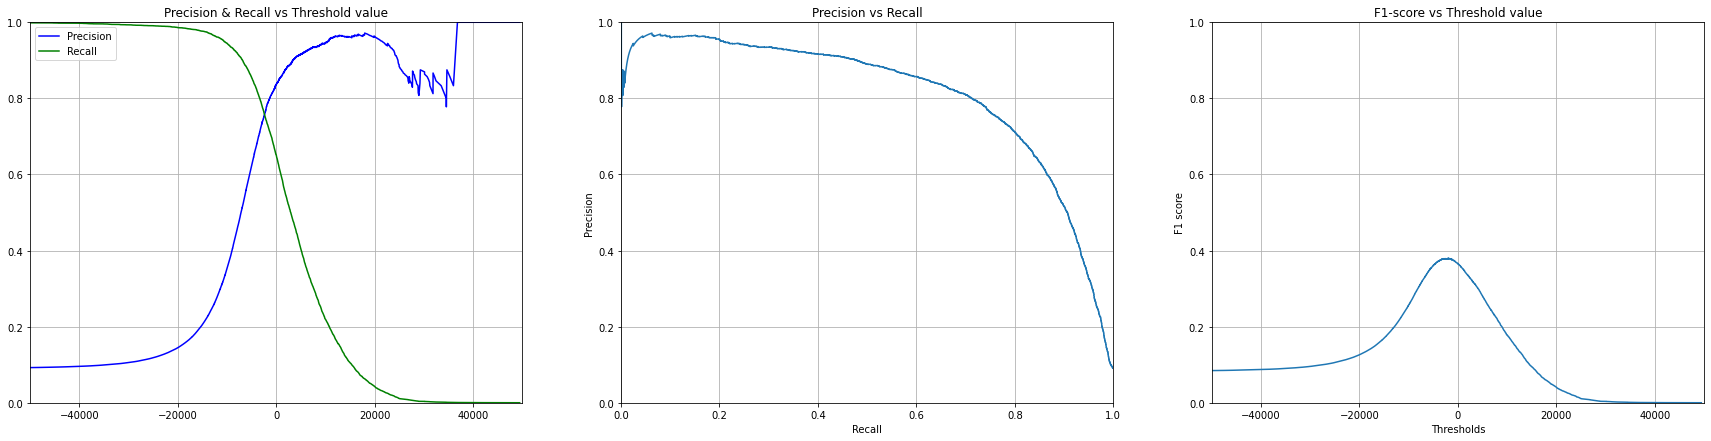

In [12]:
fig,ax = plt.subplots(1,3,figsize=(30,7))
ax[0].plot(thresholds,precisions[:-1],'b',label="Precision")
ax[0].plot(thresholds,recalls[:-1],'g',label="Recall")
ax[0].set_xlim([-50000,50000])
ax[0].set_ylim([0,1])
ax[0].grid(True)
ax[0].legend(['Precision','Recall'])
ax[0].set_title('Precision & Recall vs Threshold value');
ax[1].plot(recalls,precisions)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].grid(True)
ax[1].set_title('Precision vs Recall');
ax[2].plot(thresholds,f1_score)
ax[2].set_xlabel('Thresholds')
ax[2].set_ylabel('F1 score')
ax[2].set_xlim([-50000,50000])
ax[2].set_ylim([0,1])
ax[2].grid(True)
ax[2].set_title('F1-score vs Threshold value');

In [13]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print("Threshold for 90% precision:",threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_90 = precision_score(y_train_5,y_train_pred_90)
recall_90 = recall_score(y_train_5,y_train_pred_90)
print("Precision: ", precision_90)
print("Recall:", recall_90)

Threshold for 90% precision: 3370.0194991439557
Precision:  0.9000345901072293
Recall: 0.4799852425751706


### ROC Curve
ROC or the Receiver Operating Characteristic is another common metric used with binary classifiers. The ROC curve plots the $TPR$ (true positive rate) against the $FPR$ (false positive rate) where $\text{FPR} = 1 - \text{TNR}$, $\text{TNR}$ is the true negative rate or the specificity. The ROC curve is a plot of $\text{sensitivity (recall) vs } 1-\text{specificity}$

From the confusion matrix above,

$\text{TPR} = \text{Recall} = \frac{3530}{3530+1891} = 0.651$

$\text{FPR} = 1-\text{TNR} = 1-\frac{53892}{53892+687} = 0.987$



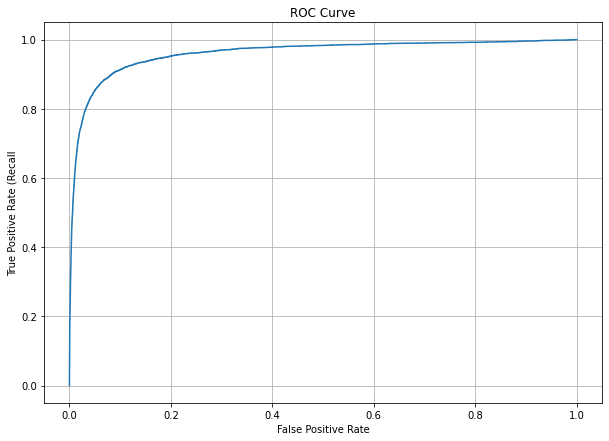

In [14]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds_roc = roc_curve(y_train_5,y_scores)
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(fpr,tpr)
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall')
ax.grid(True)

### Area under ROC Curve (AUC)
The area under the ROC curve (AUC) is another useful metric to measure classifier performance.

In [15]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_5,y_scores)
print("###########################")
print("#######  ROC AUC   ########")
print("###########################")
print(auc)

###########################
#######  ROC AUC   ########
###########################
0.9604938554008616


## Comparison of SGD vs Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")
y_scores_forest = y_probas_forest[:,1] # score = probability of positive class

precisions_forest,recalls_forest,thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)
f1_score_forest = []
for i in range(len(thresholds_forest)):
  f1_score_forest += [1/(1/precisions_forest[i] + 1/recalls_forest[i])]

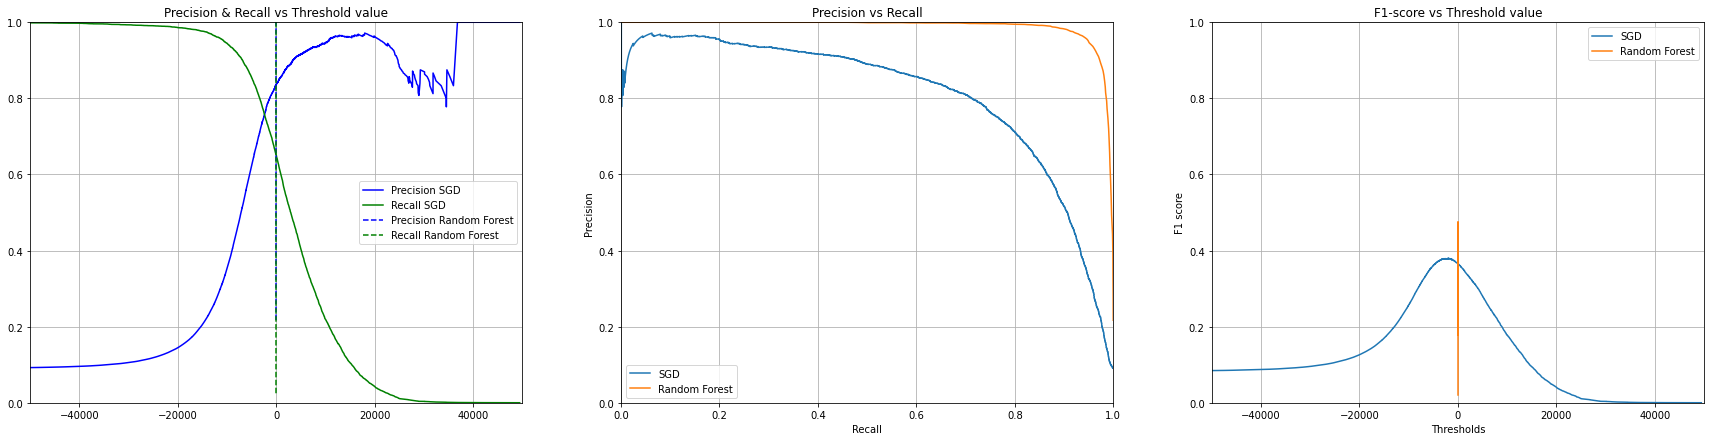

In [17]:
fig,ax = plt.subplots(1,3,figsize=(30,7))
ax[0].plot(thresholds,precisions[:-1],'b',label="Precision")
ax[0].plot(thresholds,recalls[:-1],'g',label="Recall")
ax[0].plot(thresholds_forest,precisions_forest[:-1],'b--',label="Precision")
ax[0].plot(thresholds_forest,recalls_forest[:-1],'g--',label="Recall")
ax[0].set_xlim([-50000,50000])
ax[0].set_ylim([0,1])
ax[0].grid(True)
ax[0].legend(['Precision SGD','Recall SGD','Precision Random Forest','Recall Random Forest'])
ax[0].set_title('Precision & Recall vs Threshold value');
ax[1].plot(recalls,precisions)
ax[1].plot(recalls_forest,precisions_forest)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].grid(True)
ax[1].legend(['SGD','Random Forest'])
ax[1].set_title('Precision vs Recall');
ax[2].plot(thresholds,f1_score)
ax[2].plot(thresholds_forest,f1_score_forest)
ax[2].set_xlabel('Thresholds')
ax[2].set_ylabel('F1 score')
ax[2].set_xlim([-50000,50000])
ax[2].set_ylim([0,1])
ax[2].grid(True)
ax[2].set_title('F1-score vs Threshold value');
ax[2].legend(['SGD','Random Forest']);

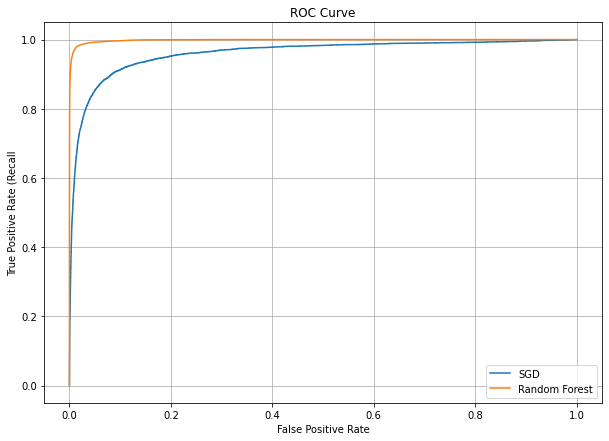

In [18]:
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(fpr,tpr)
ax.plot(fpr_forest,tpr_forest)
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall')
ax.legend(['SGD','Random Forest'])
ax.grid(True)

In [19]:
auc_forest = roc_auc_score(y_train_5,y_scores_forest)
print("###########################")
print("#######  ROC AUC   ########")
print("###########################")
print(auc_forest)

###########################
#######  ROC AUC   ########
###########################
0.9983436731328145


## Multiclass Classification

In [20]:
## Scaling the input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
score = cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")
print("Cross validation score:", score)

Cross validation score: [0.8983 0.891  0.9018]


### Confusion Matrix

In [22]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
cfn_mtx = confusion_matrix(y_train,y_train_pred)
norm_cfn_mtx = cfn_mtx/cfn_mtx.sum(axis=1,keepdims=True)

Text(0.5, 1.05, 'Normalized Confusion Matrix')

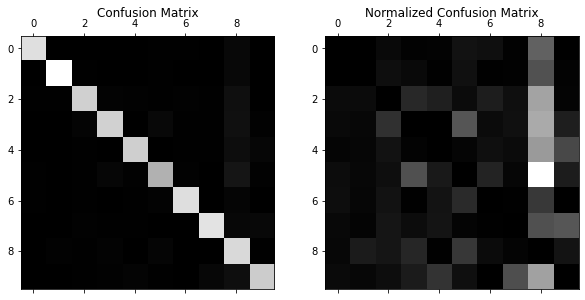

In [25]:
np.fill_diagonal(norm_cfn_mtx,0)
fig,ax = plt.subplots(1,2,figsize=(10,7))
ax[0].matshow(cfn_mtx,cmap=plt.cm.gray)
ax[0].set_title('Confusion Matrix')
ax[1].matshow(norm_cfn_mtx,cmap=plt.cm.gray)
ax[1].set_title('Normalized Confusion Matrix')